In [1]:
from google.colab import drive

ModuleNotFoundError: No module named 'google.colab'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Importing initial libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
from skimage.io import imread,imshow,imsave
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
np.version.version

'1.19.2'

In [3]:
import os
import string

# Deleting 'handwriting' folder if it already exists in the directory

In [ ]:
!rm -rf '/content/sample_data/handwriting'

# Creating a directory in which files will get extracted

In [4]:
path='/home/rijul/Downloads/mid_proj2/handwriting'
#os.mkdir(path)
os.chdir(path)
os.getcwd()

'/home/rijul/Downloads/mid_proj2/handwriting'

In [ ]:
!tar xfz '/home/rijul/Downloads/mid_proj2/words.tgz'

# Function to read and process images and labels from parser.txt file 

In [5]:
def read_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

data = read_file('/home/rijul/Downloads/mid_proj2/parser.txt')
data = data.split('\n')
data[:10]

#Encoding function:

characters = string.ascii_letters + string.digits + string.punctuation
def encoder(txt):
    output = []
    for index, character in enumerate(txt):
        output.append(characters.index(character))
    return output
print(characters,len(characters))

def transform(image):
    width , height = image.shape

    new_width = 32
    new_height = int(height * (new_width / width))
    image = cv2.resize(image, (new_height , new_width))
    image = image.astype('float32')
    width , height = image.shape

    if width < 32:
        add_zeros = np.full((32-width, height), 255)
        image = np.concatenate((image, add_zeros))
        width , height = image.shape

    if height < 128:
        add_zeros = np.full((width , 128-height), 255)
        image = np.concatenate((image, add_zeros), axis=1)
        width , height = image.shape

    if height > 128 or width > 32:
        dim = (128,32)
        image = cv2.resize(image, dim)

    image = cv2.subtract(255, image)
    # Expanding the dimension of image
    image = np.expand_dims(image, axis=2)
    # Normalize the image
    image = image / 255
    return image


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 94


# Creating train and validation datasets

In [6]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

max_len = 0

for index, line in enumerate(data):
    splits = line.split(' ')
    status = splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = path+'/{}/{}-{}/{}.png'.format(splits_id[0], splits_id[0], splits_id[1],word_id)
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = transform(img)
        except:
            continue
        # processing on label
        try:
            label = encoder(word)
        except:
            continue
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(16)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(16)
            train_label_length.append(len(word))
            train_original_text.append(word)
        if len(word) > max_len:
            max_len = len(word)
    if index >= 10000:
        break

# Length of the longest word in the data:

In [7]:
print(max_len)

16


# Padding the encoded labels to the maximum length of a sample word (with a value beyond the index of number of characters to avoid model misunderstanding padding values with characters[0] ie, 'a')

In [8]:
train_padded_labels=tf.keras.preprocessing.sequence.pad_sequences(train_labels,maxlen=max_len,padding='post',value=len(characters))
valid_padded_labels=tf.keras.preprocessing.sequence.pad_sequences(valid_labels,maxlen=max_len,padding='post',value=len(characters))

In [9]:
train_padded_labels[1]

array([19, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
      dtype=int32)

In [10]:
train_padded_labels[:10]

array([[38, 40, 47, 30, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [19, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [18, 19, 14, 15, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [38, 17, 75, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [32,  0,  8, 19, 18, 10,  4, 11, 11, 94, 94, 94, 94, 94, 94, 94],
       [ 5, 17, 14, 12, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [13, 14, 12,  8, 13,  0, 19,  8, 13,  6, 94, 94, 94, 94, 94, 94],
       [ 0, 13, 24, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [12, 14, 17,  4, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94],
       [11,  8,  5,  4, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94]],
      dtype=int32)

# Converting all the inputs to numpy array

In [11]:
train_images,valid_images=np.array(train_images),np.array(valid_images)
train_padded_labels,valid_padded_labels=np.array(train_padded_labels),np.array(valid_padded_labels)
train_label_length,valid_label_length=np.array(train_label_length),np.array(valid_label_length)
train_input_length,valid_input_length=np.array(train_input_length),np.array(valid_input_length)

In [12]:
print(train_images.shape)
print(train_padded_labels.shape)
print(train_input_length.shape)
print(train_label_length.shape)

(7850, 32, 128, 1)
(7850, 16)
(7850,)
(7850,)


# Visualizing the data (images and raw labels)

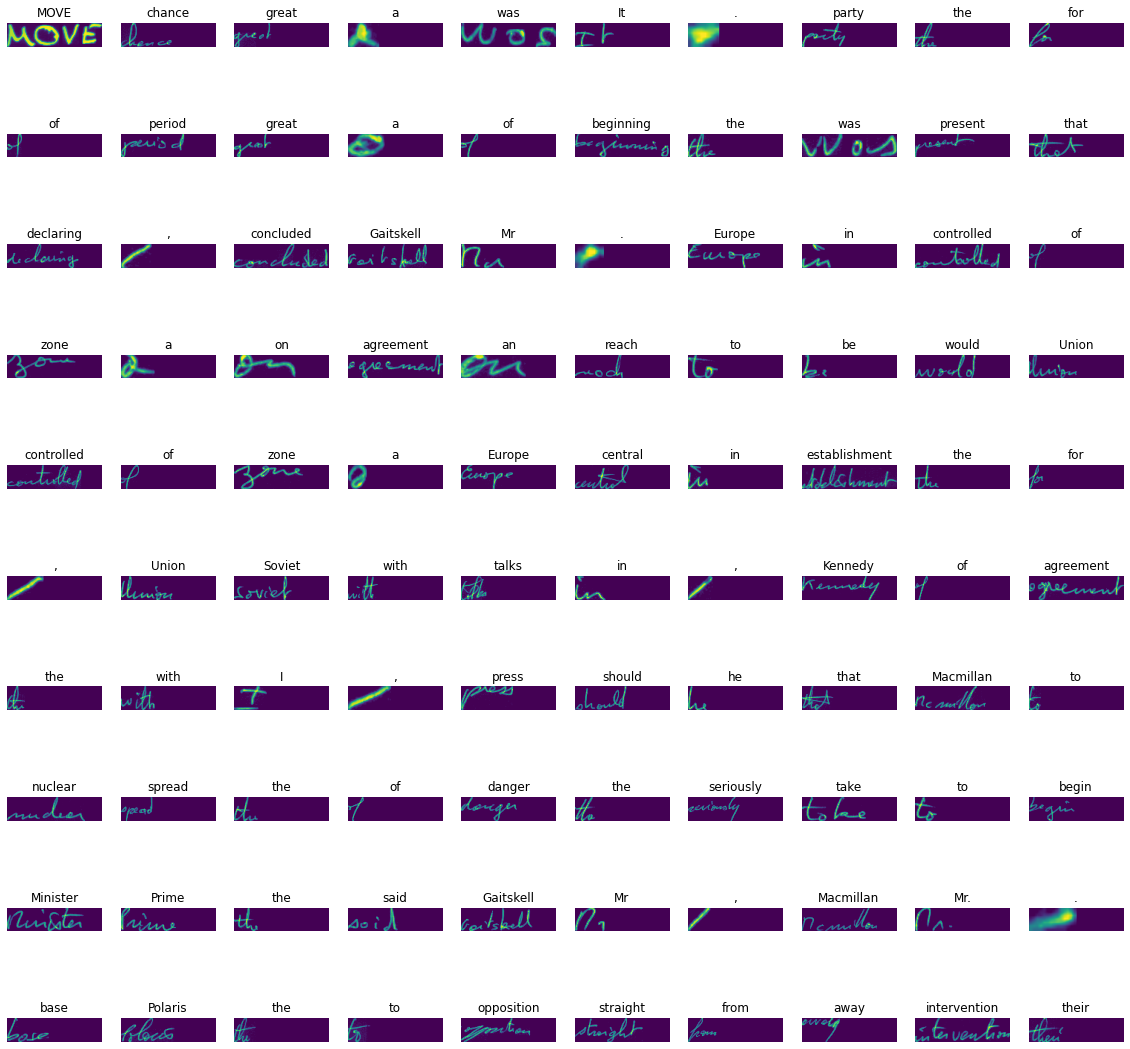

In [13]:
fig=plt.figure(figsize=(20,20))
row,col=10,10
for i in range(row*col):
  fig.add_subplot(row,col,i+1)
  plt.imshow(train_images[-i].reshape(32,128))
  plt.axis('off')
  plt.title(train_original_text[-i])


# Importing deep learning libraries 

In [14]:
from keras.models import *
from keras.layers import *
from keras.layers import concatenate
import tensorflow as tf
from keras import backend as K
from keras.backend import ctc_batch_cost, ctc_decode
import keras

# The following dimension (width of an image) will be provided as a sequence dimension to the bi-directional LSTM layer

In [15]:
train_images.shape[1]

32

# **Model Architecture**
The images have been downsampled only using maxpool for easy calculation of output shape. The sequence length is the width dimension which has been downsampled from 32 to 16. Therefore, input length is 16 

In [16]:
inputs=Input(shape=(train_images.shape[1],train_images.shape[2],1),name='image')
labels = Input(name='label', shape=[max_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


path1=(Conv2D(64,(3,3),padding='same',activation='relu'))(inputs)
path2=(Conv2D(64,(5,5),padding='same',activation='relu'))(inputs)

conv_out=concatenate([path1,path2])
conv_out=MaxPool2D(2)(conv_out)

conv2=(Conv2D(128,(3,3),padding='same',activation='relu'))(conv_out)

pool=MaxPool2D(2,2)(conv2)

conv3=(Conv2D(128,(3,3),padding='same',activation='relu'))(pool)
conv3=(Conv2D(128,(3,3),padding='same',activation='relu'))(conv3)

pool2=MaxPool2D((2,1))(conv3)

conv4=(Conv2D(256,(3,3),padding='same',activation='relu'))(pool2)
conv5=(Conv2D(256,(3,3),padding='same',activation='relu'))(conv4)
pool3=MaxPool2D(2,2)(conv5)

conv6=(Conv2D(512,(3,3),padding='same',activation='relu'))(pool3)
pool4=MaxPool2D((2,1))(conv6)


conv6=(Conv2D(512,(3,3),padding='same',activation='relu'))(pool3)
pool4=MaxPool2D((2,1))(conv6)




x = Reshape(target_shape=(16,512), name="reshape")(pool4)

#rnn=Bidirectional(LSTM(512,return_sequences=True,dropout=0.3))(x)
x=Bidirectional(LSTM(512,return_sequences=True,dropout=0.3))(x)




outputs=TimeDistributed(Dense(len(characters)+1,activation='softmax'),name='softmax')(x)

interim_model=Model(inputs=inputs,outputs=outputs)
interim_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 128, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  1664        image[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 128, 128) 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [ ]:
pip install -U numpy==1.19.2

In [17]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])



In [18]:
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss)

batch_size = 16
epochs = 30
e = str(epochs)
optimizer = 'adam'

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer)


In [ ]:
file_path="/content/drive/MyDrive/mid_proj2/models/model-{}e-{}p.h5".format(str(epochs),str(optimizer))

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

callbacks=[checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_labels, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_labels, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks
                    )
model.save(file_path)

In [19]:
pred_model=Model(model.get_layer(name='image').input,model.get_layer(name='softmax').output)

pred_model.load_weights(filepath='/home/rijul/Downloads/model-30e-adamp.h5')




In [20]:
# predict outputs on validation images
prediction = pred_model.predict(valid_images)


In [21]:
import keras.backend as K
decoded = K.ctc_decode(prediction,input_length=np.ones(prediction.shape[0]) * prediction.shape[1],greedy=True)[0][0]
output = K.get_value(decoded)


In [22]:
pred_words=[]
for i in output:
  pred=''
  for x in i:
    if x!=-1:
      pred+=characters[int(x)]
  pred_words.append(pred)

Predicted word : .       ||       Actual word : A


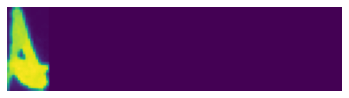

Predicted word : Labour       ||       Actual word : Labour


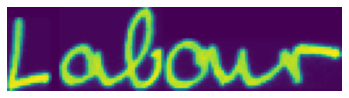

Predicted word : of       ||       Actual word : of


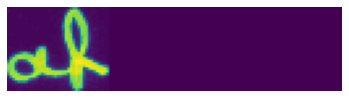

Predicted word : down       ||       Actual word : down


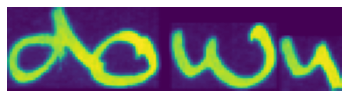

Predicted word : Exchange       ||       Actual word : Exchange


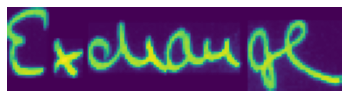

Predicted word : lay       ||       Actual word : any


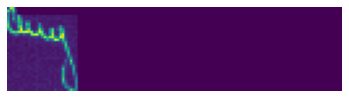

Predicted word : a       ||       Actual word : a


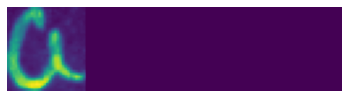

Predicted word : han       ||       Actual word : has


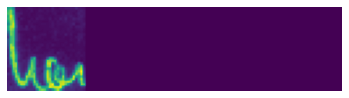

Predicted word : is       ||       Actual word : is


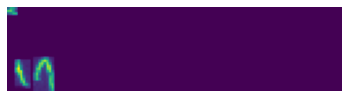

Predicted word : fo       ||       Actual word : for


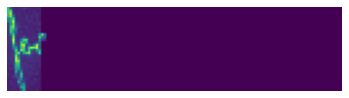

Predicted word : support       ||       Actual word : support


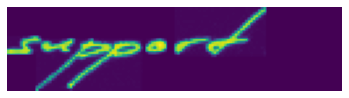

Predicted word : to       ||       Actual word : to


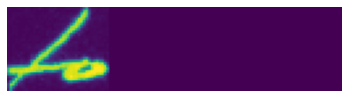

Predicted word : will       ||       Actual word : will


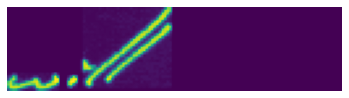

Predicted word : whral       ||       Actual word : which


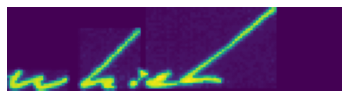

Predicted word : now       ||       Actual word : now


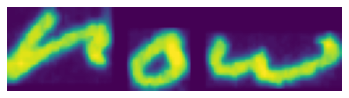

Predicted word : of       ||       Actual word : of


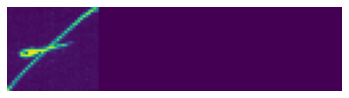

Predicted word : tabe       ||       Actual word : take


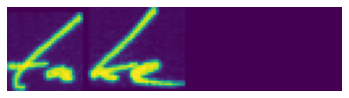

Predicted word : reft-wing       ||       Actual word : Left-wing


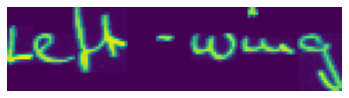

Predicted word : likely       ||       Actual word : likely


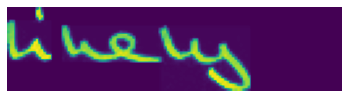

Predicted word : Goverment       ||       Actual word : Government


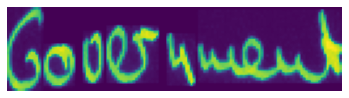

Predicted word : schould       ||       Actual word : should


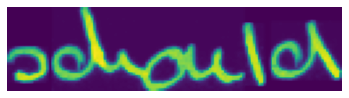

Predicted word : the       ||       Actual word : the


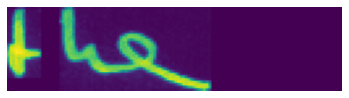

Predicted word : should       ||       Actual word : should


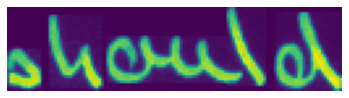

Predicted word : prop       ||       Actual word : prop


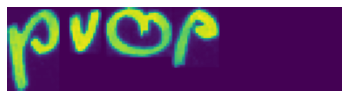

Predicted word : lhly       ||       Actual word : likely


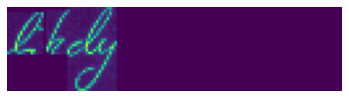

Predicted word : met       ||       Actual word : ment


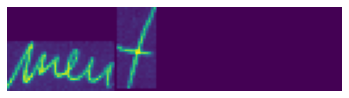

Predicted word : should       ||       Actual word : should


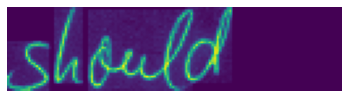

Predicted word : the       ||       Actual word : the


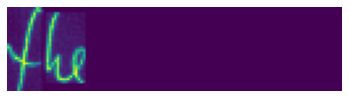

Predicted word : should       ||       Actual word : should


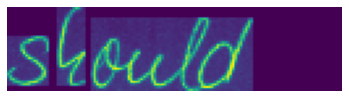

Predicted word : prop       ||       Actual word : prop


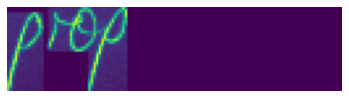

Predicted word : 13       ||       Actual word : 13


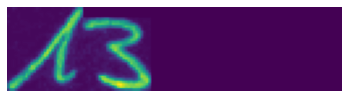

Predicted word : Most       ||       Actual word : Most


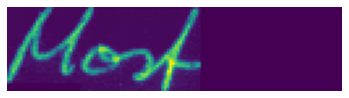

Predicted word : the       ||       Actual word : the


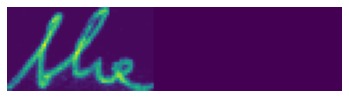

Predicted word : has       ||       Actual word : has


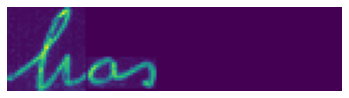

Predicted word : tus       ||       Actual word : two


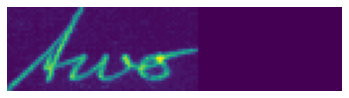

Predicted word : to       ||       Actual word : to


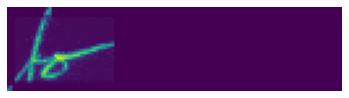

Predicted word : Wielernsly       ||       Actual word : Welensky


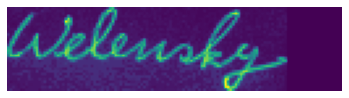

Predicted word : Labour       ||       Actual word : Labour


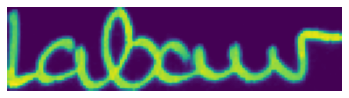

Predicted word : Labour       ||       Actual word : Labour


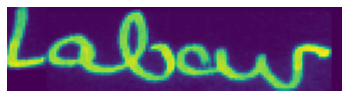

Predicted word : of       ||       Actual word : of


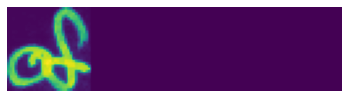

Predicted word : have       ||       Actual word : have


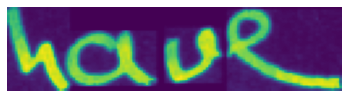

Predicted word : African       ||       Actual word : African


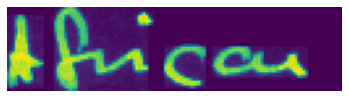

Predicted word : together       ||       Actual word : together


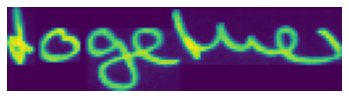

Predicted word : the       ||       Actual word : the


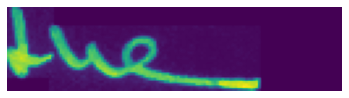

Predicted word : Peeis       ||       Actual word : Peers


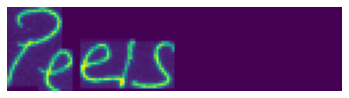

Predicted word : sentment       ||       Actual word : sentiment


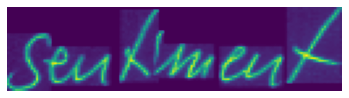

Predicted word : Rords       ||       Actual word : Lords


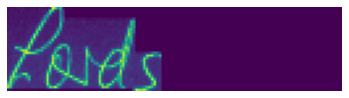

Predicted word : an       ||       Actual word : an


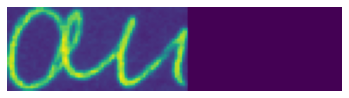

Predicted word : Natieonalist       ||       Actual word : Nationalist


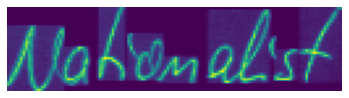

Predicted word : to       ||       Actual word : to


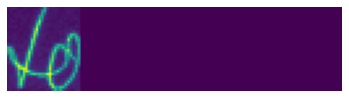

Predicted word : Federal       ||       Actual word : Federal


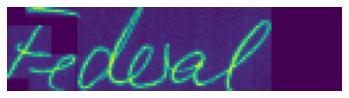

Predicted word : Independend       ||       Actual word : Independence


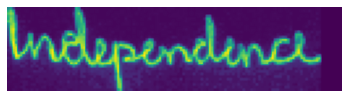

Predicted word : today       ||       Actual word : today


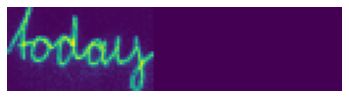

Predicted word : Roy       ||       Actual word : Roy


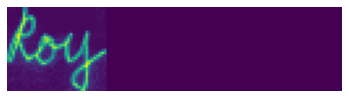

Predicted word : in       ||       Actual word : in


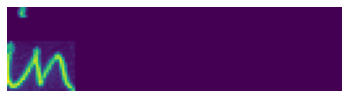

Predicted word : hain       ||       Actual word : Iain


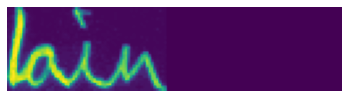

Predicted word : .       ||       Actual word : .


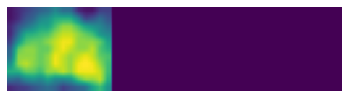

Predicted word : ,       ||       Actual word : (


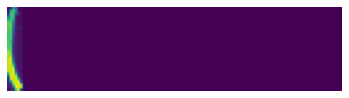

Predicted word : Couguess       ||       Actual word : Congress


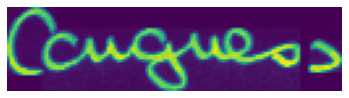

Predicted word : discuss       ||       Actual word : discuss


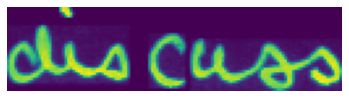

Predicted word : violently       ||       Actual word : violently


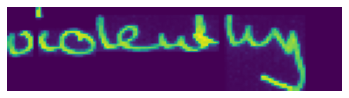

Predicted word : Rhodesia       ||       Actual word : Rhodesia


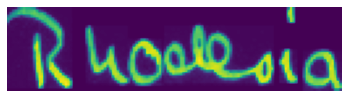

Predicted word : ,       ||       Actual word : ,


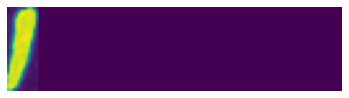

Predicted word : imitly       ||       Actual word : insisting


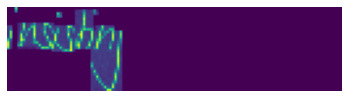

Predicted word : Federak       ||       Actual word : Federal


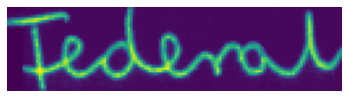

Predicted word : future       ||       Actual word : future


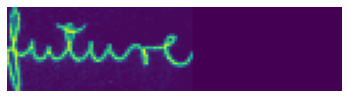

Predicted word : want       ||       Actual word : want


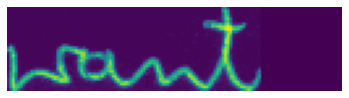

Predicted word : gives       ||       Actual word : gives


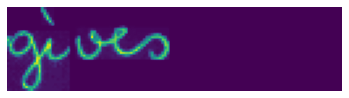

Predicted word : .       ||       Actual word : .


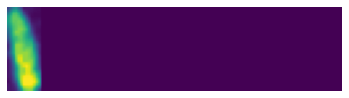

Predicted word : his       ||       Actual word : his


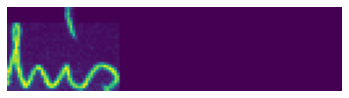

Predicted word : at       ||       Actual word : at


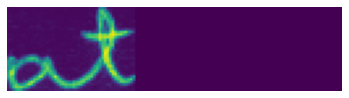

Predicted word : the       ||       Actual word : the


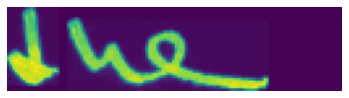

Predicted word : to       ||       Actual word : to


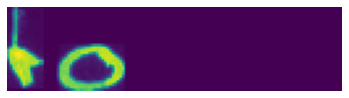

Predicted word : Ray's       ||       Actual word : Roy's


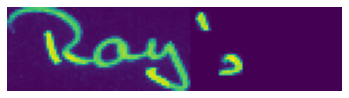

Predicted word : chief       ||       Actual word : chief


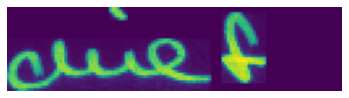

Predicted word : Cheavers       ||       Actual word : Chequers


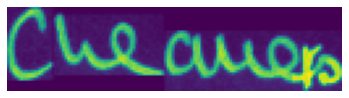

Predicted word : dondom       ||       Actual word : London


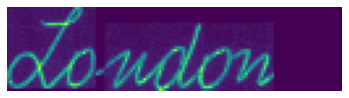

Predicted word : lait       ||       Actual word : last


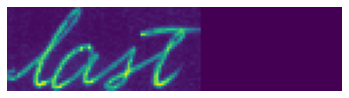

Predicted word : do       ||       Actual word : do


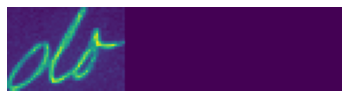

Predicted word : and       ||       Actual word : and


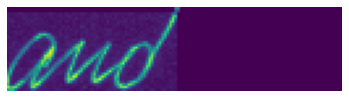

Predicted word : be       ||       Actual word : be


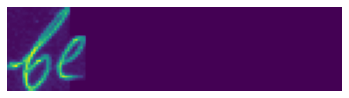

Predicted word : Mr.       ||       Actual word : Mr.


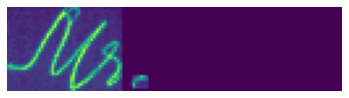

Predicted word : his       ||       Actual word : his


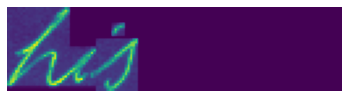

Predicted word : went       ||       Actual word : went


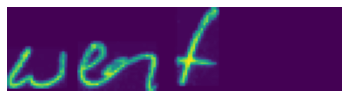

Predicted word : crrisis       ||       Actual word : crisis


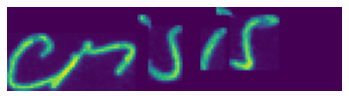

Predicted word : his       ||       Actual word : his


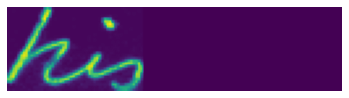

Predicted word : These       ||       Actual word : These


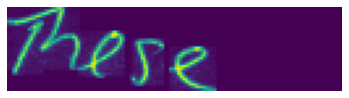

Predicted word : they       ||       Actual word : they


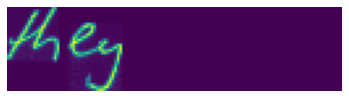

Predicted word : .       ||       Actual word : .


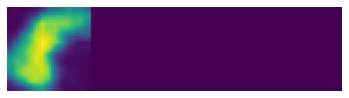

Predicted word : a       ||       Actual word : a


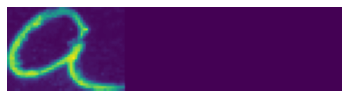

Predicted word : with       ||       Actual word : with


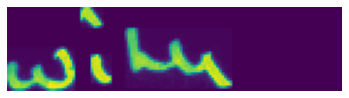

Predicted word : had       ||       Actual word : had


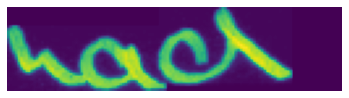

Predicted word : plans       ||       Actual word : plans


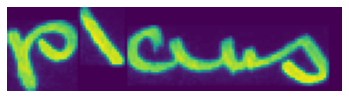

Predicted word : do       ||       Actual word : do


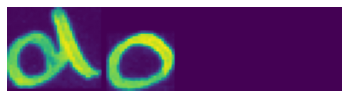

Predicted word : seehing       ||       Actual word : seeking


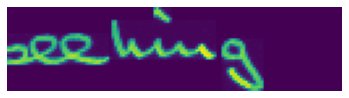

Predicted word : conference       ||       Actual word : conference


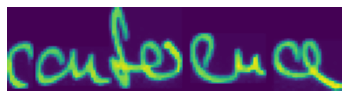

Predicted word : House       ||       Actual word : House


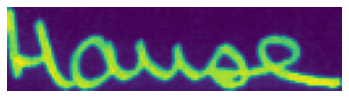

Predicted word : conference       ||       Actual word : conference


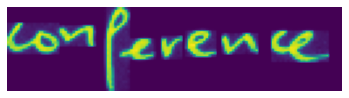

Predicted word : up       ||       Actual word : up


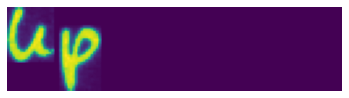

Predicted word : the       ||       Actual word : the


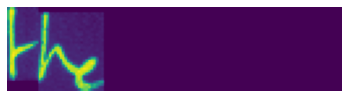

In [27]:
for i in range(100):
  print('Predicted word : {}       ||       Actual word : {}'.format(pred_words[i],valid_original_text[i]))
  plt.imshow(valid_images[i].reshape(32,128))
  plt.axis('off')
  plt.show()

The model performs well, most of the errors have occured where handwriting is almost illegible to even human eyes. 

In [28]:
from english_words import english_words_set

In [24]:
os.chdir('/home/rijul')

In [25]:
from nltk.corpus import words

In [31]:
type(english_words_set)

set

In [26]:
all_words= words.words()

In [43]:
'labour' in all_words

True

In [52]:
lower_pred=[]
encoded_lower=[]
for i in pred_words:
    lower_pred.append(i.lower())
    encoded_lower.append(encoder(i))

In [53]:
encoded_lower[:10]

[[75],
 [37, 0, 1, 14, 20, 17],
 [14, 5],
 [3, 14, 22, 13],
 [30, 23, 2, 7, 0, 13, 6, 4],
 [11, 0, 24],
 [0],
 [7, 0, 13],
 [8, 18],
 [5, 14]]

In [29]:
all_encoded_words=[]
for i in all_words:
    all_encoded_words.append(encoder(i))

In [30]:
all_encoded_words[:10]

[[26],
 [0],
 [0, 0],
 [0, 0, 11],
 [0, 0, 11, 8, 8],
 [0, 0, 12],
 [26, 0, 13, 8],
 [0, 0, 17, 3, 21, 0, 17, 10],
 [0, 0, 17, 3, 22, 14, 11, 5],
 [26, 0, 17, 14, 13]]

In [54]:
all_padded_words=tf.keras.preprocessing.sequence.pad_sequences(all_encoded_words,maxlen=max_len,padding='post',value=-1)
lower_padded=tf.keras.preprocessing.sequence.pad_sequences(encoded_lower,maxlen=max_len,padding='post',value=-1)

In [32]:
all_padded_words[1]

array([ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int32)

In [33]:
valid_padded_labels=tf.keras.preprocessing.sequence.pad_sequences(valid_labels,maxlen=max_len,padding='post',value=-1)

In [35]:
from sklearn.neighbors import KDTree
from scipy import spatial

In [36]:
tree=spatial.KDTree(list(all_padded_words))

In [60]:
for i in output:
    min_dist= float('inf')
    for j in range(len(valid_padded_labels)):
        index = np.argmin(np.abs(i-j))
        

KeyboardInterrupt: 

In [57]:
index = np.argmin(np.abs(np.array(a)-11.5))

inf

In [79]:
valid_original_text[:10]

['A', 'Labour', 'of', 'down', 'Exchange', 'any', 'a', 'has', 'is', 'for']

In [78]:
valid_padded_labels[:10]

array([[26, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [37,  0,  1, 14, 20, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [14,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 3, 14, 22, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [30, 23,  2,  7,  0, 13,  6,  4, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0, 13, 24, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 7,  0, 18, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 8, 18, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 5, 14, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
      dtype=int32)

In [42]:
output[1]

array([37,  0,  1, 14, 20, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [55]:
correct_encoded=[]
for i in lower_padded:
    d,ind= tree.query(i)
    correct_encoded.append(all_padded_words[ind])

In [56]:
correct_words=[]
for i in correct_encoded:
    correct=''
    for x in i:
        if x!=-1:
            correct+=characters[int(x)]
    correct_words.append(correct)

In [57]:
'labour' in all_words

True

In [58]:
for i in range(100):
    print('Corrected word : {}  ||  Predicted word : {}       ||       Actual word : {}'
          .format(correct_words[i],pred_words[i],valid_original_text[i]))


Corrected word : Z  ||  Predicted word : .       ||       Actual word : A
Corrected word : Labrus  ||  Predicted word : Labour       ||       Actual word : Labour
Corrected word : of  ||  Predicted word : of       ||       Actual word : of
Corrected word : down  ||  Predicted word : down       ||       Actual word : down
Corrected word : Auchenia  ||  Predicted word : Exchange       ||       Actual word : Exchange
Corrected word : lay  ||  Predicted word : lay       ||       Actual word : any
Corrected word : a  ||  Predicted word : a       ||       Actual word : a
Corrected word : han  ||  Predicted word : han       ||       Actual word : has
Corrected word : is  ||  Predicted word : is       ||       Actual word : is
Corrected word : go  ||  Predicted word : fo       ||       Actual word : for
Corrected word : support  ||  Predicted word : support       ||       Actual word : support
Corrected word : to  ||  Predicted word : to       ||       Actual word : to
Corrected word : will  |

# Spare/alternate model

In [ ]:
inputs=Input(shape=(train_images.shape[1],train_images.shape[2],1),name='image')
labels = Input(name='label', shape=[max_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


path1=(Conv2D(64,(3,3),padding='same',activation='relu'))(inputs)
path2=(Conv2D(64,(5,5),padding='same',activation='relu'))(inputs)

conv_out=concatenate([path1,path2])
conv_out=MaxPool2D(2)(conv_out)

conv2=(Conv2D(128,(3,3),padding='same',activation='relu'))(conv_out)

pool=MaxPool2D(2,2)(conv2)

conv3=(Conv2D(128,(3,3),padding='same',activation='relu'))(pool)

pool2=MaxPool2D((2,1))(conv3)

conv4=(Conv2D(256,(3,3),padding='same',activation='relu'))(pool2)
conv5=(Conv2D(256,(3,3),padding='same',activation='relu'))(conv4)
pool3=MaxPool2D(2,2)(conv5)

conv6=(Conv2D(256,(3,3),padding='same',activation='relu'))(pool3)
pool4=MaxPool2D((2,1))(conv6)


conv6=(Conv2D(512,(3,3),padding='same',activation='relu'))(pool3)
pool4=MaxPool2D((2,1))(conv6)




x = Reshape(target_shape=(16,512), name="reshape")(pool4)

rnn=Bidirectional(LSTM(256,return_sequences=True,dropout=0.3))(x)
x=Bidirectional(LSTM(256,return_sequences=True,dropout=0.3))(x)




outputs=TimeDistributed(Dense(len(characters),activation='softmax'),name='softmax')(x)

interim_model=Model(inputs=inputs,outputs=outputs)
interim_model.summary()
